In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import netCDF4
import xarray as xr
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

C:\Users\pkoll\AppData\Local\Temp\ipykernel_5896\4031092812.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [12]:
#### MIGHTI ####
#### FUV ####
L1f_fn_01 = 'ICON_L1_FUV_SWP_2020-01-01_v05r000.NC'

#LOADING IN THE DATA
dsf_raw = xr.open_dataset(L1f_fn,engine = 'netcdf4')
dsf_raw


<xarray.Dataset>
Dimensions:                            (Epoch: 5812, Rows: 256, Stripes: 6)
Coordinates:
  * Epoch                              (Epoch) float64 1.578e+12 ... 1.578e+12
  * Rows                               (Rows) float32 0.0 1.0 ... 254.0 255.0
Dimensions without coordinates: Stripes
Data variables: (12/52)
    ICON_L1_FUVA_SWP_Start_Times       (Epoch) object ...
    ICON_L1_FUVA_SWP_Stop_Times        (Epoch) object ...
    ICON_L1_FUVA_SWP_Center_Times      (Epoch) object ...
    ICON_L1_FUVA_SWP_Integration_Time  (Epoch) float32 ...
    ICON_L1_FUVA_SWP_Chain_ID          (Epoch) float32 ...
    ICON_L1_FUVA_SWP_Quality_Flag      (Epoch) float32 ...
    ...                                 ...
    ICON_L1_FUVA_SWP_PROF_M3_CLEAN     (Epoch, Rows) float32 ...
    ICON_L1_FUVA_SWP_PROF_P0_CLEAN     (Epoch, Rows) float32 ...
    ICON_L1_FUVA_SWP_PROF_P3_CLEAN     (Epoch, Rows) float32 ...
    ICON_L1_FUVA_SWP_PROF_P6_CLEAN     (Epoch, Rows) float32 ...
    ICON_L1_FUVA_SWP_GAIN_DAY          (Stripes) float32 ...
    ICON_L1_FUVA_SWP_GAIN_NIGHT        (Stripes) float32 ...
Attributes: (12/51)
    Acknowledgement:             This is a data product from the NASA Ionosph...
    ADID_Ref:                    NASA Contract > NNG12F45C
    Calibration_File:            See calibration files in general attribute f...
    Conventions:                 SPDF ISTP/IACF Modified for NetCDF (v0.8)
    Data_Level:                  L1
    Data_Type:                   APIDxE3 > ICON Application ID 0xE3: FUV Scie...
    ...                          ...
    FLATFIELD_CORRECTION:        [1.159 1.057 1.011 0.952 0.919 0.91 ]
    BACKGROUND_CORRECTION:       BKG/ICON_L1_FUV_Calibration-Background-SW_20...
    RAYLEIGH_CONVERSION:         [0.04132072 0.04132072 0.04132072 ... 0.0413...
    File_Date:                   Thu, 28 Apr 2022, 2022-04-28T22:23:12.626 UTC
    Generation_Date:             20220428
    Software_Version:            ICON SDC > ICON FUV L1 Processor version 202...

In [6]:
def orbits_finder(df):
    #r = 148
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [7]:
def single_orb_plotter(orbit_arr,n):
    orb = orbit_arr[n].mean(dim = 'row')
    plt_title = 'Orbit ' + str(n)
    
    plt.figure()
    plt.title(plt_title)
    plt.plot(orb.time, orb.I_1356, 'C3.-') 
    plt.show()
        

In [8]:
def single_orb(orbit_arr,n):
    orb = orbit_arr[n].mean(dim = 'row')
    t = orb.time
    val = orb.I_1356
    return(t, val)

In [9]:
def fuv_plots_smoothed(orbit_data):
    dsf_plot = orbit_data.rolling(row=7, center=True).mean()
    orbit_data['I_1356_filt'] = orbit_data['I_1356'] - orbit_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    # save the mean (bg) and the pertubation separately to see if it's affecting anything
    plt.figure(figsize=(10,3))

    # FUV
    vm = abs(orbit_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    plt.pcolormesh(pd.to_datetime(orbit_data.time.values), orbit_data.row, orbit_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    plt.ylabel('row')
    plt.colorbar(label='R')
    plt.title('FUV 1356 brightness')

    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    

In [10]:
def data_opening_w_stripe(stripe,d):
    dsf_raw = xr.open_dataset(d,engine = 'netcdf4')
    dsf = dsf_raw[['ICON_L1_FUVA_SWP_Center_Times','ICON_L1_FUVA_SWP_PROF_'+str(stripe)]]
    # Convert times to something Python and xarray can understand, and reindex the dataset by time instead of the obscure "Epoch"
    t = pd.to_datetime(dsf.ICON_L1_FUVA_SWP_Center_Times.values)
    dsf['time'] = (['Epoch'], t)
    dsf = dsf.swap_dims({'Epoch':'time'})
    dsf = dsf.rename({'Rows':'row'})
    # Rename and drop useless variables
    dsf['I_1356'] = dsf['ICON_L1_FUVA_SWP_PROF_'+str(stripe)]
    dsf = dsf.drop(['ICON_L1_FUVA_SWP_PROF_'+str(stripe),'ICON_L1_FUVA_SWP_Center_Times','Epoch'])
    return dsf

### ALL LINES

In [13]:
df_01_p3 = data_opening_w_stripe('P3',L1f_fn_01)
df_01_p6 = data_opening_w_stripe('P6',L1f_fn_01)
#df_01_p9 = data_opening_w_stripe('P9',L1f_fn_01)
df_01_m3 = data_opening_w_stripe('M3',L1f_fn_01)
df_01_m6 = data_opening_w_stripe('M6',L1f_fn_01)
df_01_m9 = data_opening_w_stripe('M9',L1f_fn_01)


In [14]:
p_3_all_orbits = orbits_finder(df_01_p3)
p_6_all_orbits = orbits_finder(df_01_p6)
m_3_all_orbits = orbits_finder(df_01_m3)
m_6_all_orbits = orbits_finder(df_01_m6)
m_9_all_orbits = orbits_finder(df_01_m9)
p_0_all_orbits = orbits_finder(df_01)

        
plt.figure()
plt.title("Comparing Stripes of FUV Data for Orbit 0 on Jan 1st, 2020")
plt.plot(single_orb(p_0_all_orbits,1)[0],single_orb(p_0_all_orbits,1)[1],marker = '.', label = 'PO')
plt.plot(single_orb(p_3_all_orbits,1)[0],single_orb(p_3_all_orbits,1)[1],marker = '.', label = 'P3')
plt.plot(single_orb(p_6_all_orbits,1)[0],single_orb(p_6_all_orbits,1)[1],marker = '.', label = 'P6')
plt.plot(single_orb(m_3_all_orbits,1)[0],single_orb(m_3_all_orbits,1)[1],marker = '.', label = 'M3')
plt.plot(single_orb(m_6_all_orbits,1)[0],single_orb(m_6_all_orbits,1)[1],marker = '.', label = 'M6')
plt.plot(single_orb(m_9_all_orbits,1)[0],single_orb(m_9_all_orbits,1)[1],marker = '.', label = 'M9')


plt.legend()
plt.show()

NameError: name 'df_01' is not defined

## FUV FILTERING PLOTS

In [ ]:
def correlations_interpolated(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    
#     row_means_1 = orbit1_data.mean(dim = 'row')
#     row_means_2 = orbit2_data.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_vals)))
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) #sanity check this 
    taus_shifted = np.fft.fftshift(taus)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) # check this with the shifted and the unshifted 
    print('index',max_index)
    
    # Calculate difference from 0
    max_difference = taus_shifted[max_index] - 0
    print('xval',taus_shifted[max_index])
    print("Difference from 0:", max_difference*1e-9)
    #print()



    # PLOT
    plt.figure()
    plt.plot(taus_shifted, V12_shifted, '.-r')
    plt.plot(taus_shifted[max_index], V12_shifted[max_index], 'bo', markersize=4)  # Emphasize max point
    plt.title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    plt.ylabel('Correlated Power')
    #plt.xlabel('Time [ns]')
    #plt.xlim(-100, 100)
    plt.axvline(0)
    plt.grid()
    plt.show()


In [ ]:
m3 = orbits_finder(orbits_finder(df_01_m3)[0])[0]
m3_label = 'M3'
m6 = orbits_finder(orbits_finder(df_01_m6)[0])[0]
m6_label = 'M6'
m9 = orbits_finder(orbits_finder(df_01_m9)[0])[0]
m9_label = 'M9'


p0 = orbits_finder(orbits_finder(df_01)[0])[0]
p0_label = 'P0'
p3 = orbits_finder(orbits_finder(df_01_p3)[0])[0]
p3_label = 'P3'
p6 = orbits_finder(orbits_finder(df_01_p6)[0])[0]
p6_label = 'P6'


In [ ]:
correlations_interpolated(m6,p0,m6_label,p0_label)

  ### TESTING SHIFTS (TAU)

##### A SHIFT TO THE LEFT (a positive tau a), correlation peak is negative

<IPython.core.display.Javascript object>


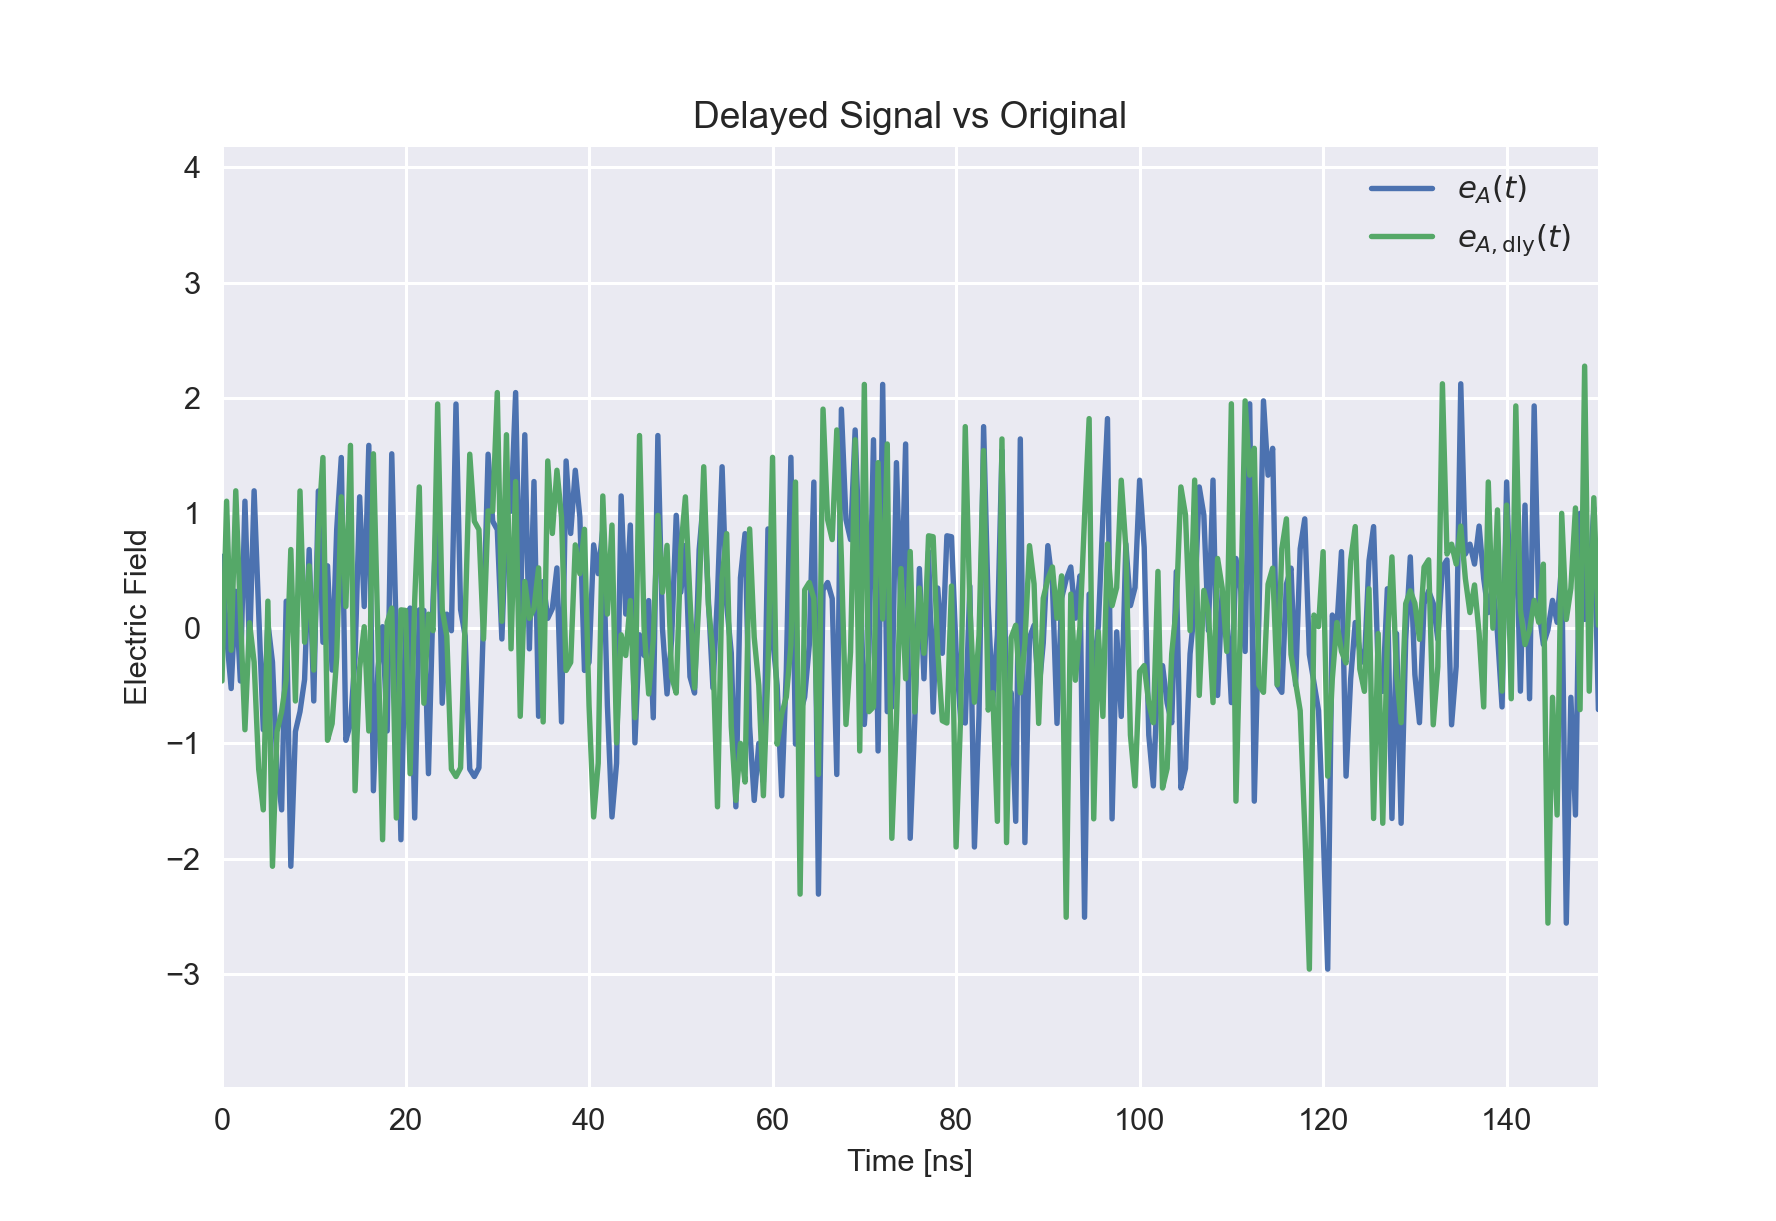

In [100]:
## TEST DATA

SIZE = 10000
t = np.arange(SIZE) * 0.5e-9 # time step of 0.5 us = 1/(2 MHz)
e_A = np.random.normal(size=SIZE)

fqs = np.fft.fftfreq(t.size, np.median(np.diff(t)))
tau_A = 2e-9

# Using the convolution theorem to introduce a geometric delay
e_A_dly = np.fft.ifft(np.fft.fft(e_A) * np.exp(2j*np.pi*tau_A*fqs)).real

v1 = e_A_dly 
v2 = e_A

plt.figure()
plt.plot(t * 1e9, e_A, label=r"$e_A(t)$")
plt.plot(t * 1e9, e_A_dly, label=r"$e_{A,{\rm dly}}(t)$")
plt.title("Delayed Signal vs Original")
plt.ylabel('Electric Field')
plt.xlabel('Time [ns]')
plt.xlim(0,150)
_ = plt.legend()
plt.show()

<IPython.core.display.Javascript object>


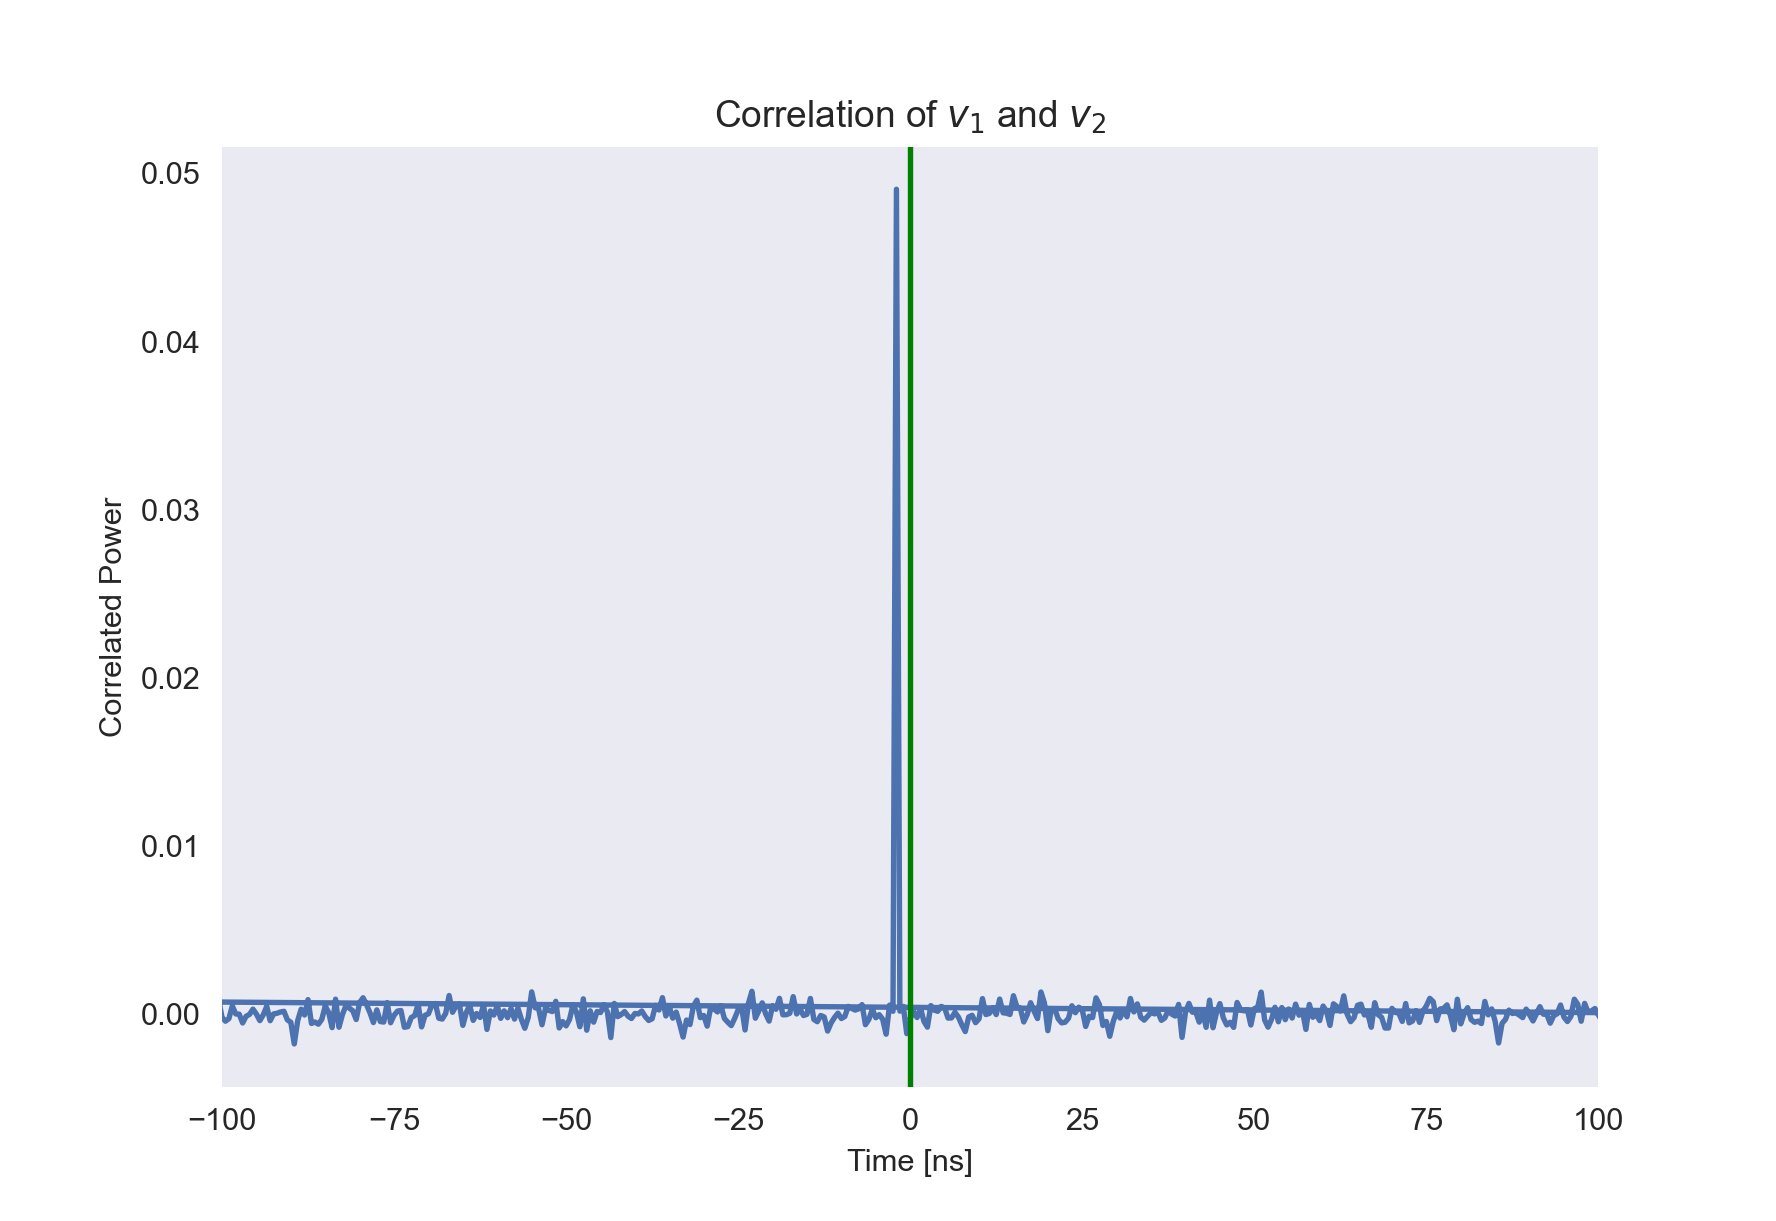

In [101]:
v1.shape = (20, 500) # Why are we reshaping it here? It's an array of 10000, are we just doing this arbitrarily?
v2.shape = (20, 500)
V12 = np.fft.fft(v1) * np.conj(np.fft.fft(v2))
V12 = np.mean(V12, axis=0)
fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t)))

taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])
plt.figure()
plt.plot(taus * 1e9, np.fft.ifft(V12) / SIZE)
plt.title('Correlation of $v_1$ and $v_2$')
plt.ylabel('Correlated Power')
plt.xlabel('Time [ns]')
plt.axvline(0, color = 'g')
plt.xlim(-100, 100)
plt.grid()

##### A SHIFT TO THE RIGHT (negative tau A),  correlation peak is positive

<IPython.core.display.Javascript object>


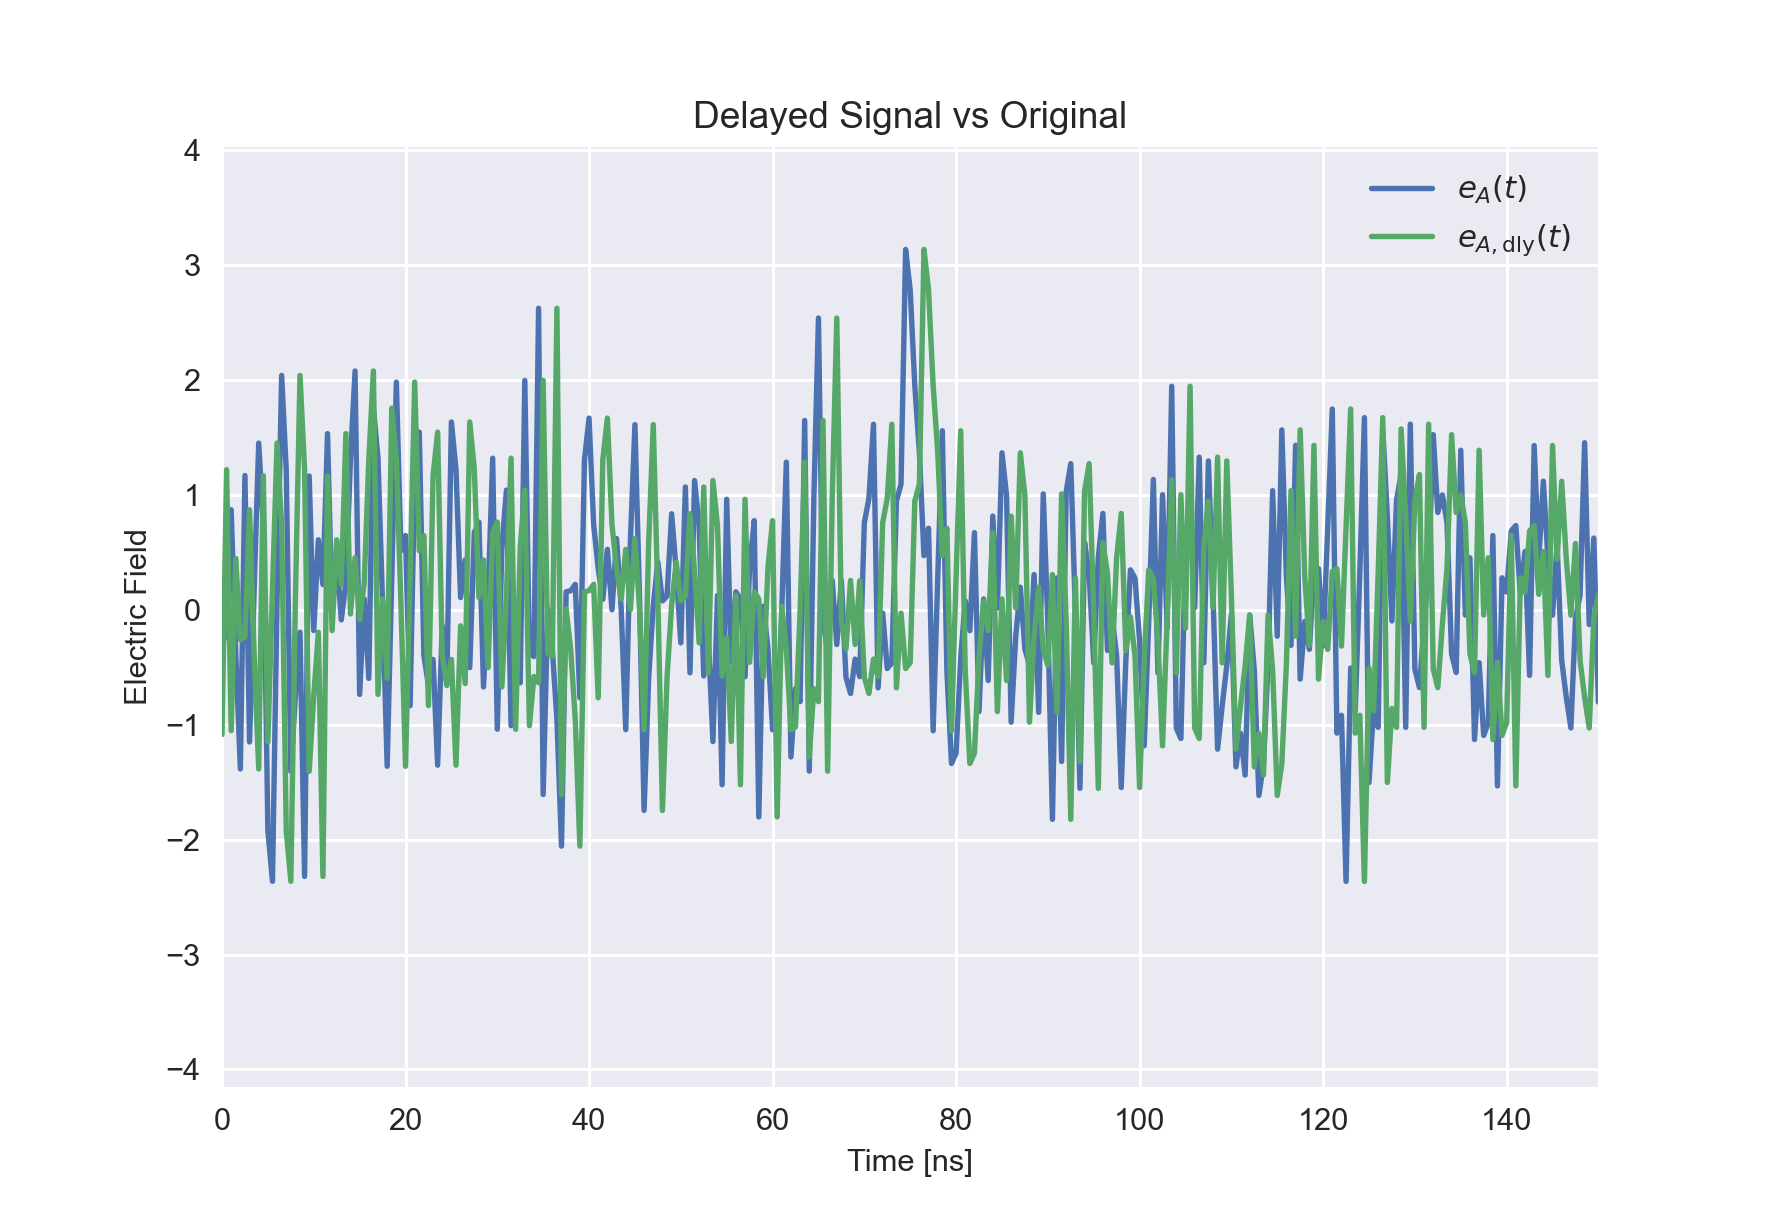

In [102]:
## TEST DATA

SIZE = 10000
t = np.arange(SIZE) * 0.5e-9 # time step of 0.5 us = 1/(2 MHz)
e_A = np.random.normal(size=SIZE)

fqs = np.fft.fftfreq(t.size, np.median(np.diff(t)))
tau_A = -2e-9

# Using the convolution theorem to introduce a geometric delay
e_A_dly = np.fft.ifft(np.fft.fft(e_A) * np.exp(2j*np.pi*tau_A*fqs)).real

v1 = e_A_dly 
v2 = e_A

plt.figure()
plt.plot(t * 1e9, e_A, label=r"$e_A(t)$")
plt.plot(t * 1e9, e_A_dly, label=r"$e_{A,{\rm dly}}(t)$")
plt.title("Delayed Signal vs Original")
plt.ylabel('Electric Field')
plt.xlabel('Time [ns]')
plt.xlim(0,150)
_ = plt.legend()
plt.show()

<IPython.core.display.Javascript object>


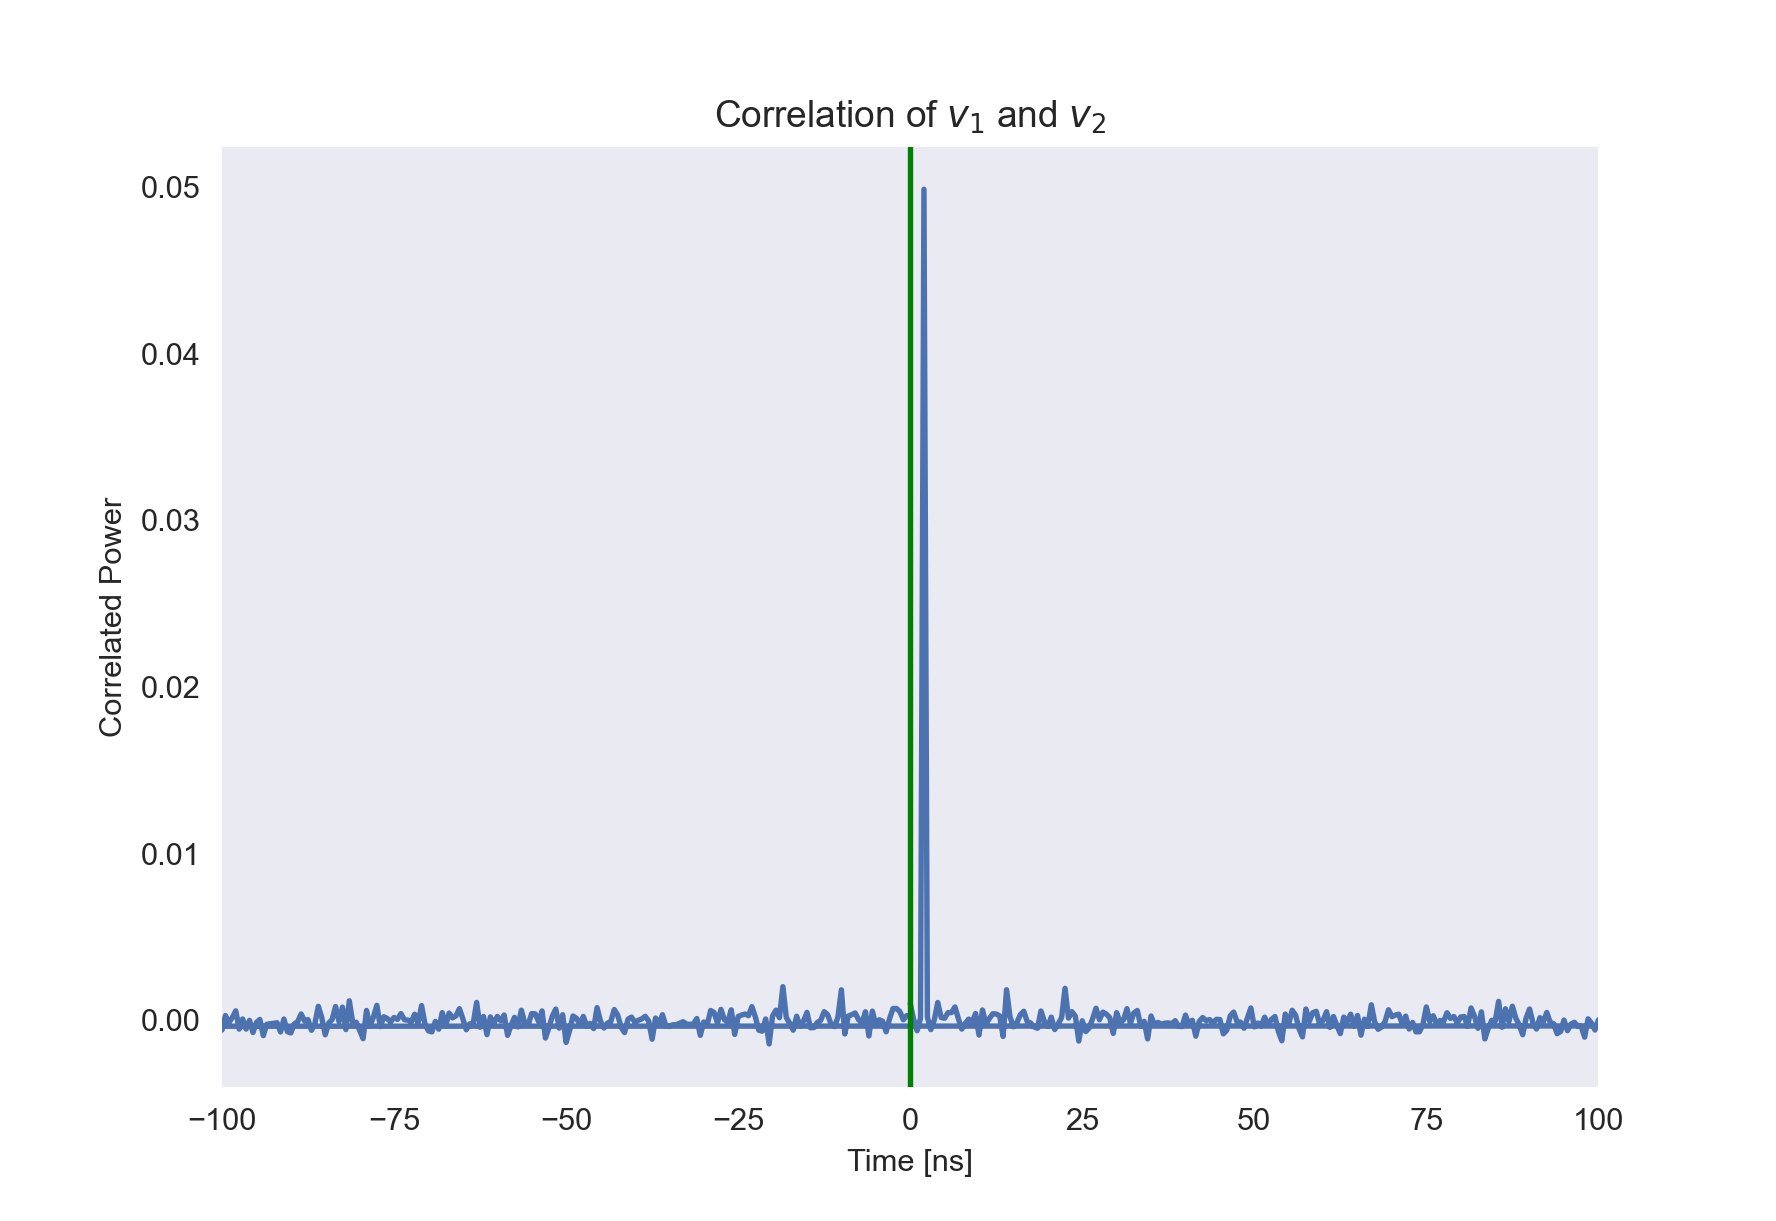

In [103]:
v1.shape = (20, 500) # Why are we reshaping it here? It's an array of 10000, are we just doing this arbitrarily?
v2.shape = (20, 500)
V12 = np.fft.fft(v1) * np.conj(np.fft.fft(v2))
V12 = np.mean(V12, axis=0)
fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t)))

taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])
plt.figure()
plt.plot(taus * 1e9, np.fft.ifft(V12) / SIZE)
plt.title('Correlation of $v_1$ and $v_2$')
plt.ylabel('Correlated Power')
plt.xlabel('Time [ns]')
plt.axvline(0, color = 'g')
plt.xlim(-100, 100)
plt.grid()